The basic idea behind GANs is actually very simple. At its core, a GAN includes two agents with competing objectives that work through opposing goals. This relatively simple setup results in both of the agent's coming up with increasingly complex ways. An analogy would be a counterfeiter trying to post fake posts and a cyber vigilante trying to ascertain and flag fake posts.This is similar to the minmax in game theory.

Consider x and z to be distributions . A generator G(z) has the objective of mapping noise to real world data , 
the input x. It tries to generate data as close as possible to the real dataset. The discriminator D(X) plays 
the role of adversary here and tries to discriminate between real world data and generated data. The discriminator 
outputs a  probability that a data came from the real world dataset. The two neural networks are trained and compete
with each other until an equilibrium is reached

The objective function is 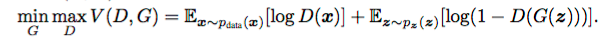

The usual desirable equilibrium point for the above defined GANs is that the Generator should model the real data and Discriminator should output the probability of 0.5 as the generated data is same as the real data -- that is, it is not sure if the new data coming from the generator is real or fake with equal probability.

So first we generate data randomnly using numpy and also another coordinate using a cubic distribution

In [1]:
import numpy as np

def get_y(x):
    return 21 + x*x


def sample_data(n=300, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)


In [2]:
import matplotlib.pyplot as plt 
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [get_y(x) for x in inputs]
# plot the result
plt.scatter(inputs, outputs)
plt.show()

<Figure size 640x480 with 1 Axes>

Now the generator

In [3]:
data = sample_data()
# plot samples


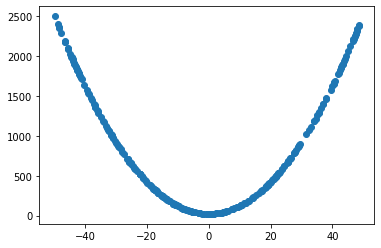

In [4]:
plt.scatter(data[:,0], data[:,1])
plt.show()

The discriminator D(X) plays the role of adversary here and tries to discriminate between real world data 
and generated data. So the discriminator is bascically a binary classification problem which tells if an image 
is fake or not. Well technically it outputs a probability that a generated image came from training data rather
than from generator.

In [5]:
!pip install torchviz

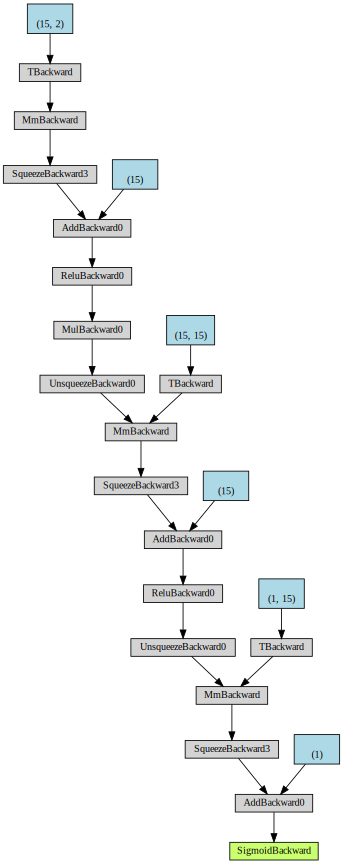

In [6]:

# define the discriminator model
import torch
from torch import nn,optim
from torchviz import make_dot
from torch.autograd import Variable


# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = nn.Sequential(nn.Linear(n_inputs, 15),
                          nn.ReLU(),
                          nn.Dropout(),
                          nn.Linear(15,15),
                           nn.ReLU(),
                          nn.Linear(15,1),
                          nn.Sigmoid()
                         )
    return model

# define the discriminator model
x = Variable(torch.from_numpy(np.random.randn(2))).float()
model  = define_discriminator()
output = model(x)
make_dot(output)

The discriminator has a hidden layer with 25 neurons and uses Relu activation

Now let us generate some real samples. to the generate samples method above let us add a small piece of code to 
return labels.

In [7]:
def generate_samples(n=100, label='real'):
    """Generate samples with real or fake label
    """
    x = np.random.randn(n, 1)
    output = get_y(x)
    
    y = np.ones((n, 1)) * (label == 'real')
    return np.hstack([x, output]), y

In [8]:
X, y = generate_samples(64)

In [9]:
X[:10]

array([[-0.61091576, 21.37321806],
       [ 0.48274208, 21.23303991],
       [-0.65266228, 21.42596805],
       [ 0.12603831, 21.01588565],
       [-0.47046936, 21.22134142],
       [-0.88787289, 21.78831827],
       [-0.5124734 , 21.26262899],
       [ 0.68821689, 21.47364248],
       [-0.91545177, 21.83805193],
       [-1.8685725 , 24.49156318]])

In [10]:
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

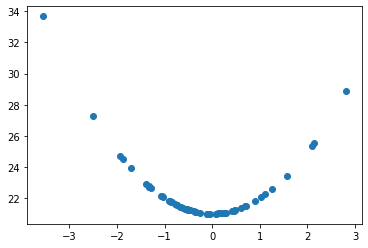

In [11]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [12]:
def generate_fake_labelled_samples(n=100, label='fake'):
    """Generate samples with real or fake label
    """
    x = np.random.randn(n, 1) *2 + -1
    output = get_y(x)
    
    y = np.zeros((n, 1)) * (label == 'fake')
    return np.hstack([x, output]), y

In [13]:
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:

d_steps = 100
g_steps = 100
def train_discriminator(model, n_epochs=3000, n_batch=128):
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        running_loss=0
        running_fake_loss=0
        model.zero_grad()
        X_real, y_real = generate_samples(half_batch)
        X_real = Variable(torch.from_numpy(X_real))
        output = model(X_real.float())
        y_real = Variable(torch.FloatTensor(y_real))
        loss = criterion(output, y_real)
        loss.backward()
        X_fake,y_fake = generate_fake_labelled_samples(half_batch)
        X_fake = Variable(torch.from_numpy(X_fake))
        fake_output = model(X_fake.float())
        fake_loss = criterion(fake_output, torch.FloatTensor(y_fake))
        fake_loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_fake_loss += fake_loss.item()

        print(f"Real samples Training loss: {running_loss}")
        print(f"Fake samples Training loss: {running_fake_loss}")

In [15]:
discriminator_model =  define_discriminator()
train_discriminator(discriminator_model)

Real samples Training loss: 0.5061293244361877
Fake samples Training loss: 1.3122004270553589
Real samples Training loss: 0.5037865042686462
Fake samples Training loss: 1.3725450038909912
Real samples Training loss: 0.530781090259552
Fake samples Training loss: 1.1039958000183105
Real samples Training loss: 0.5081878304481506
Fake samples Training loss: 1.3019990921020508
Real samples Training loss: 0.456003338098526
Fake samples Training loss: 1.2855772972106934
Real samples Training loss: 0.42575809359550476
Fake samples Training loss: 1.3216420412063599
Real samples Training loss: 0.5013777613639832
Fake samples Training loss: 1.2441879510879517
Real samples Training loss: 0.46350333094596863
Fake samples Training loss: 1.4911941289901733
Real samples Training loss: 0.5149351954460144
Fake samples Training loss: 1.273166298866272
Real samples Training loss: 0.5286311507225037
Fake samples Training loss: 1.2764523029327393
Real samples Training loss: 0.4643946588039398
Fake samples T

Real samples Training loss: 0.44388213753700256
Fake samples Training loss: 1.3728642463684082
Real samples Training loss: 0.41726699471473694
Fake samples Training loss: 1.2781851291656494
Real samples Training loss: 0.4738675057888031
Fake samples Training loss: 1.324444055557251
Real samples Training loss: 0.4689196050167084
Fake samples Training loss: 1.2562659978866577
Real samples Training loss: 0.5508899092674255
Fake samples Training loss: 1.1989325284957886
Real samples Training loss: 0.5112167596817017
Fake samples Training loss: 1.2527469396591187
Real samples Training loss: 0.4845787584781647
Fake samples Training loss: 1.1421329975128174
Real samples Training loss: 0.5000032782554626
Fake samples Training loss: 1.2388046979904175
Real samples Training loss: 0.5572108030319214
Fake samples Training loss: 1.3806313276290894
Real samples Training loss: 0.4426211714744568
Fake samples Training loss: 1.0796878337860107
Real samples Training loss: 0.47106310725212097
Fake sample

Real samples Training loss: 0.4394242465496063
Fake samples Training loss: 1.197134017944336
Real samples Training loss: 0.48554369807243347
Fake samples Training loss: 1.2338180541992188
Real samples Training loss: 0.48290789127349854
Fake samples Training loss: 1.2937018871307373
Real samples Training loss: 0.5477156043052673
Fake samples Training loss: 1.3605079650878906
Real samples Training loss: 0.45119351148605347
Fake samples Training loss: 1.2071284055709839
Real samples Training loss: 0.48487696051597595
Fake samples Training loss: 1.120561957359314
Real samples Training loss: 0.4533323347568512
Fake samples Training loss: 1.1358752250671387
Real samples Training loss: 0.5011807680130005
Fake samples Training loss: 1.2180891036987305
Real samples Training loss: 0.418171226978302
Fake samples Training loss: 1.309892177581787
Real samples Training loss: 0.5182958841323853
Fake samples Training loss: 1.3030768632888794
Real samples Training loss: 0.5115092992782593
Fake samples 

Real samples Training loss: 0.48866844177246094
Fake samples Training loss: 1.1885137557983398
Real samples Training loss: 0.4432678818702698
Fake samples Training loss: 1.2470284700393677
Real samples Training loss: 0.48796823620796204
Fake samples Training loss: 1.2047443389892578
Real samples Training loss: 0.4847966134548187
Fake samples Training loss: 1.296773076057434
Real samples Training loss: 0.4573221802711487
Fake samples Training loss: 1.2384283542633057
Real samples Training loss: 0.49927210807800293
Fake samples Training loss: 1.36741042137146
Real samples Training loss: 0.4402545988559723
Fake samples Training loss: 1.1464837789535522
Real samples Training loss: 0.5428867936134338
Fake samples Training loss: 1.2385475635528564
Real samples Training loss: 0.48604872822761536
Fake samples Training loss: 1.3171658515930176
Real samples Training loss: 0.4566912055015564
Fake samples Training loss: 1.3312000036239624
Real samples Training loss: 0.47643929719924927
Fake sample

Real samples Training loss: 0.48375484347343445
Fake samples Training loss: 1.2777926921844482
Real samples Training loss: 0.48760277032852173
Fake samples Training loss: 1.2449361085891724
Real samples Training loss: 0.44094306230545044
Fake samples Training loss: 1.1327190399169922
Real samples Training loss: 0.4595966041088104
Fake samples Training loss: 1.0651408433914185
Real samples Training loss: 0.5699142813682556
Fake samples Training loss: 1.2205259799957275
Real samples Training loss: 0.47339344024658203
Fake samples Training loss: 1.141525149345398
Real samples Training loss: 0.4515455365180969
Fake samples Training loss: 1.276634931564331
Real samples Training loss: 0.44729968905448914
Fake samples Training loss: 1.0499223470687866
Real samples Training loss: 0.4692080616950989
Fake samples Training loss: 1.3724358081817627
Real samples Training loss: 0.5010554194450378
Fake samples Training loss: 1.1272255182266235
Real samples Training loss: 0.482797771692276
Fake sample

Real samples Training loss: 0.4591583013534546
Fake samples Training loss: 1.1661522388458252
Real samples Training loss: 0.5076692700386047
Fake samples Training loss: 1.3147306442260742
Real samples Training loss: 0.5221908688545227
Fake samples Training loss: 1.2430232763290405
Real samples Training loss: 0.4409486949443817
Fake samples Training loss: 1.2344807386398315
Real samples Training loss: 0.4946812093257904
Fake samples Training loss: 1.418971061706543
Real samples Training loss: 0.4448060691356659
Fake samples Training loss: 1.234413743019104
Real samples Training loss: 0.43738752603530884
Fake samples Training loss: 1.1992288827896118
Real samples Training loss: 0.45156243443489075
Fake samples Training loss: 1.1177952289581299
Real samples Training loss: 0.5281597971916199
Fake samples Training loss: 1.19268000125885
Real samples Training loss: 0.44225576519966125
Fake samples Training loss: 1.3051879405975342
Real samples Training loss: 0.5052037835121155
Fake samples T

Real samples Training loss: 0.5052912831306458
Fake samples Training loss: 1.249782681465149
Real samples Training loss: 0.4816110134124756
Fake samples Training loss: 1.4094637632369995
Real samples Training loss: 0.4851190447807312
Fake samples Training loss: 1.1671102046966553
Real samples Training loss: 0.4466707408428192
Fake samples Training loss: 1.5398043394088745
Real samples Training loss: 0.41222789883613586
Fake samples Training loss: 1.2382502555847168
Real samples Training loss: 0.47033944725990295
Fake samples Training loss: 1.1507799625396729
Real samples Training loss: 0.453389436006546
Fake samples Training loss: 1.5961079597473145
Real samples Training loss: 0.5114468932151794
Fake samples Training loss: 1.2011302709579468
Real samples Training loss: 0.5045715570449829
Fake samples Training loss: 1.2067800760269165
Real samples Training loss: 0.5099182724952698
Fake samples Training loss: 1.2089262008666992
Real samples Training loss: 0.4441966116428375
Fake samples 

Real samples Training loss: 0.48967376351356506
Fake samples Training loss: 1.3938281536102295
Real samples Training loss: 0.5767343044281006
Fake samples Training loss: 1.2033610343933105
Real samples Training loss: 0.5672666430473328
Fake samples Training loss: 1.4145516157150269
Real samples Training loss: 0.501390278339386
Fake samples Training loss: 1.2030644416809082
Real samples Training loss: 0.4140281677246094
Fake samples Training loss: 1.203892707824707
Real samples Training loss: 0.4494147002696991
Fake samples Training loss: 1.2011196613311768
Real samples Training loss: 0.45762011408805847
Fake samples Training loss: 1.296699047088623
Real samples Training loss: 0.4667462408542633
Fake samples Training loss: 1.434253454208374
Real samples Training loss: 0.43540409207344055
Fake samples Training loss: 1.3907099962234497
Real samples Training loss: 0.4583800435066223
Fake samples Training loss: 1.3032366037368774
Real samples Training loss: 0.45763808488845825
Fake samples 

Real samples Training loss: 0.47779715061187744
Fake samples Training loss: 1.2808232307434082
Real samples Training loss: 0.4740827679634094
Fake samples Training loss: 1.2096697092056274
Real samples Training loss: 0.5002649426460266
Fake samples Training loss: 1.2929435968399048
Real samples Training loss: 0.4891529381275177
Fake samples Training loss: 1.2975142002105713
Real samples Training loss: 0.4145019054412842
Fake samples Training loss: 1.1690689325332642
Real samples Training loss: 0.4726288616657257
Fake samples Training loss: 1.1824476718902588
Real samples Training loss: 0.4659959375858307
Fake samples Training loss: 1.3511486053466797
Real samples Training loss: 0.48760366439819336
Fake samples Training loss: 1.0964720249176025
Real samples Training loss: 0.47095704078674316
Fake samples Training loss: 1.18824303150177
Real samples Training loss: 0.4801654517650604
Fake samples Training loss: 1.2436249256134033
Real samples Training loss: 0.5126186013221741
Fake samples

Real samples Training loss: 0.557274580001831
Fake samples Training loss: 1.226719856262207
Real samples Training loss: 0.44394510984420776
Fake samples Training loss: 1.1744263172149658
Real samples Training loss: 0.4932575523853302
Fake samples Training loss: 1.3844138383865356
Real samples Training loss: 0.48791295289993286
Fake samples Training loss: 1.0988250970840454
Real samples Training loss: 0.5102052688598633
Fake samples Training loss: 1.069177508354187
Real samples Training loss: 0.4673663377761841
Fake samples Training loss: 1.25159752368927
Real samples Training loss: 0.5312507748603821
Fake samples Training loss: 1.3075616359710693
Real samples Training loss: 0.5543920397758484
Fake samples Training loss: 1.0620665550231934
Real samples Training loss: 0.4959753453731537
Fake samples Training loss: 1.3465276956558228
Real samples Training loss: 0.483873188495636
Fake samples Training loss: 1.1932356357574463
Real samples Training loss: 0.515789806842804
Fake samples Train

Real samples Training loss: 0.41681233048439026
Fake samples Training loss: 1.3366881608963013
Real samples Training loss: 0.4531225562095642
Fake samples Training loss: 1.2217310667037964
Real samples Training loss: 0.4667012393474579
Fake samples Training loss: 1.232901692390442
Real samples Training loss: 0.4616532027721405
Fake samples Training loss: 1.1982862949371338
Real samples Training loss: 0.43264174461364746
Fake samples Training loss: 1.2120401859283447
Real samples Training loss: 0.5099674463272095
Fake samples Training loss: 1.131259560585022
Real samples Training loss: 0.4776438772678375
Fake samples Training loss: 1.2112473249435425
Real samples Training loss: 0.5375850200653076
Fake samples Training loss: 1.2436844110488892
Real samples Training loss: 0.44246503710746765
Fake samples Training loss: 1.2899467945098877
Real samples Training loss: 0.49885547161102295
Fake samples Training loss: 1.2751392126083374
Real samples Training loss: 0.5133713483810425
Fake sample

Real samples Training loss: 0.38547831773757935
Fake samples Training loss: 1.1591230630874634
Real samples Training loss: 0.47654908895492554
Fake samples Training loss: 1.4377838373184204
Real samples Training loss: 0.4331575334072113
Fake samples Training loss: 1.231176733970642
Real samples Training loss: 0.4765367805957794
Fake samples Training loss: 1.1051397323608398
Real samples Training loss: 0.49682989716529846
Fake samples Training loss: 1.2849785089492798
Real samples Training loss: 0.5201462507247925
Fake samples Training loss: 1.2400367259979248
Real samples Training loss: 0.5350037217140198
Fake samples Training loss: 1.316571831703186
Real samples Training loss: 0.4903305470943451
Fake samples Training loss: 1.2694706916809082
Real samples Training loss: 0.5480263233184814
Fake samples Training loss: 1.1068782806396484
Real samples Training loss: 0.5387601852416992
Fake samples Training loss: 1.2843842506408691
Real samples Training loss: 0.5067285895347595
Fake samples

Real samples Training loss: 0.5075874328613281
Fake samples Training loss: 1.2767069339752197
Real samples Training loss: 0.5011410117149353
Fake samples Training loss: 1.209609031677246
Real samples Training loss: 0.561060905456543
Fake samples Training loss: 1.360368251800537
Real samples Training loss: 0.4956732988357544
Fake samples Training loss: 1.2191922664642334
Real samples Training loss: 0.49237191677093506
Fake samples Training loss: 1.3407833576202393
Real samples Training loss: 0.4702903926372528
Fake samples Training loss: 1.360749363899231
Real samples Training loss: 0.47486594319343567
Fake samples Training loss: 1.240267276763916
Real samples Training loss: 0.5781522393226624
Fake samples Training loss: 1.298391580581665
Real samples Training loss: 0.4736701548099518
Fake samples Training loss: 1.2885713577270508
Real samples Training loss: 0.48887500166893005
Fake samples Training loss: 1.2809511423110962
Real samples Training loss: 0.4831644296646118
Fake samples Tra

Real samples Training loss: 0.4996854066848755
Fake samples Training loss: 1.3562690019607544
Real samples Training loss: 0.457155704498291
Fake samples Training loss: 1.3171899318695068
Real samples Training loss: 0.4878997504711151
Fake samples Training loss: 1.1952111721038818
Real samples Training loss: 0.5036983489990234
Fake samples Training loss: 1.2941161394119263
Real samples Training loss: 0.47090041637420654
Fake samples Training loss: 1.1230273246765137
Real samples Training loss: 0.4564599394798279
Fake samples Training loss: 1.2863454818725586
Real samples Training loss: 0.4786820113658905
Fake samples Training loss: 1.3264249563217163
Real samples Training loss: 0.49393850564956665
Fake samples Training loss: 1.239558458328247
Real samples Training loss: 0.49120405316352844
Fake samples Training loss: 1.2012323141098022
Real samples Training loss: 0.47039732336997986
Fake samples Training loss: 1.3259788751602173
Real samples Training loss: 0.390549898147583
Fake samples

Real samples Training loss: 0.49769046902656555
Fake samples Training loss: 1.1605275869369507
Real samples Training loss: 0.5455095171928406
Fake samples Training loss: 1.1235169172286987
Real samples Training loss: 0.4447062313556671
Fake samples Training loss: 1.2300119400024414
Real samples Training loss: 0.47151562571525574
Fake samples Training loss: 1.2544020414352417
Real samples Training loss: 0.4628189206123352
Fake samples Training loss: 1.285996913909912
Real samples Training loss: 0.4648343026638031
Fake samples Training loss: 1.3424540758132935
Real samples Training loss: 0.5494853854179382
Fake samples Training loss: 1.2290998697280884
Real samples Training loss: 0.5153069496154785
Fake samples Training loss: 1.3204360008239746
Real samples Training loss: 0.46312516927719116
Fake samples Training loss: 1.0808591842651367
Real samples Training loss: 0.4867176413536072
Fake samples Training loss: 1.257237195968628
Real samples Training loss: 0.47789663076400757
Fake sample

Real samples Training loss: 0.47571074962615967
Fake samples Training loss: 1.276076078414917
Real samples Training loss: 0.45156535506248474
Fake samples Training loss: 1.0916298627853394
Real samples Training loss: 0.4518890976905823
Fake samples Training loss: 1.336490511894226
Real samples Training loss: 0.4494737684726715
Fake samples Training loss: 1.1494672298431396
Real samples Training loss: 0.4450019299983978
Fake samples Training loss: 1.314070224761963
Real samples Training loss: 0.47896143794059753
Fake samples Training loss: 1.3753470182418823
Real samples Training loss: 0.48195764422416687
Fake samples Training loss: 1.1115721464157104
Real samples Training loss: 0.486150860786438
Fake samples Training loss: 1.1973589658737183
Real samples Training loss: 0.5085659027099609
Fake samples Training loss: 1.1732348203659058
Real samples Training loss: 0.501758337020874
Fake samples Training loss: 1.2303144931793213
Real samples Training loss: 0.4681656062602997
Fake samples T

In [16]:
X, y = generate_samples(64)
discriminator_model(torch.from_numpy(X).float())

tensor([[0.8465],
        [0.6038],
        [0.5488],
        [0.5307],
        [0.4677],
        [0.9347],
        [0.6792],
        [0.7909],
        [0.7896],
        [0.7920],
        [0.8475],
        [0.7878],
        [0.4252],
        [0.4030],
        [0.8023],
        [0.5922],
        [0.7251],
        [0.4534],
        [0.6176],
        [0.8727],
        [0.4964],
        [0.6127],
        [0.4838],
        [0.8891],
        [0.4872],
        [0.6352],
        [0.7892],
        [0.4882],
        [0.6954],
        [0.6657],
        [0.7957],
        [0.5689],
        [0.4117],
        [0.8102],
        [0.7154],
        [0.8292],
        [0.7977],
        [0.7661],
        [0.9056],
        [0.3527],
        [0.8888],
        [0.7041],
        [0.9210],
        [0.7894],
        [0.8046],
        [0.5350],
        [0.9502],
        [0.4232],
        [0.7101],
        [0.7320],
        [0.6874],
        [0.6775],
        [0.5622],
        [0.7694],
        [0.9192],
        [0

The generator model takes as input a point from the latent space and generates a new sample. A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.

This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space.


Let us use gaussian distribution to represent the variables in the latent space. We will generate new inputs by 
drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

Inputs: Point in latent space i.e  vector of Gaussian random numbers.
Outputs: Two-element vector representing a generated sample for our function (x and 21 + x*x).

In [17]:
def define_generator(n_inputs):
    model = nn.Sequential(nn.Linear(n_inputs, 15),
                          nn.ReLU(),
                          nn.Dropout(),
                          nn.Linear(15,15),
                          nn.ReLU(),
                          nn.Linear(15, 2), # 2 here refers to number of outputs(can be parameterized)
                         )
    return model

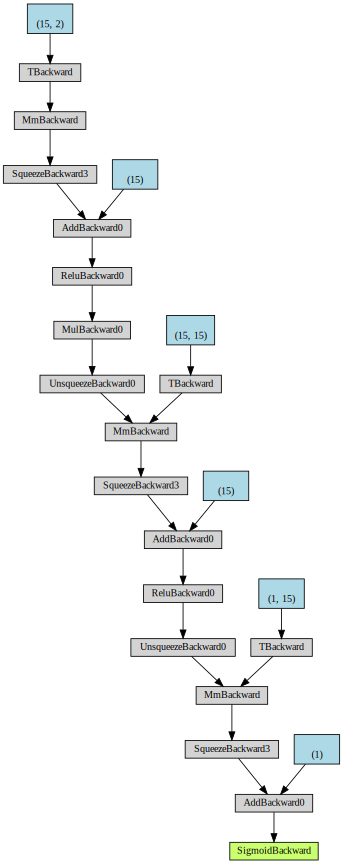

In [18]:

model  = define_generator(5)

make_dot(output)

In [19]:
model

Sequential(
  (0): Linear(in_features=5, out_features=15, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=15, out_features=15, bias=True)
  (4): ReLU()
  (5): Linear(in_features=15, out_features=2, bias=True)
)

In [20]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [21]:
import matplotlib.pyplot as plt
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    x_input = Variable(torch.from_numpy(x_input)).float()
    X = generator(x_input)
    X = X.data.numpy()
    return X

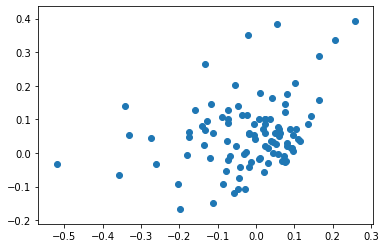

In [22]:
latent_dim = 5
# define the discriminator model
generator_model = define_generator(latent_dim)
# generate and plot generated samples
X = generate_fake_samples(generator_model, latent_dim, 100)
# plot the results
plt.scatter(X[:, 0], X[:, 1])
plt.show()

The generator has not been trained and hence it does not generate the plot we expect . once we train 
it using the discriminator we will get the shape on the original data as seen in the first plot

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the 
discriminator model is relatively poor or confused when detecting fake samples,
the generator model is updated less

This illustrates that both are adversaries.

In [23]:
# criterion for generator
criterion1 = nn.BCELoss()
optimizer1 = optim.SGD(generator_model.parameters(), lr=0.001, momentum=0.9)

In [24]:
# def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
# # prepare real samples
#     x_real, y_real = generate_samples(n)
#     # evaluate discriminator on real examples
#     _, acc_real = discriminator.eval(x_real, y_real)
#     # prepare fake examples
#     x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
#     # evaluate discriminator on fake examples
#     _, acc_fake = discriminator.eval(x_fake, y_fake)
#     # summarize discriminator performance
#     print(epoch, acc_real, acc_fake)
#     # scatter plot real and fake data points
#     plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
#     plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
#     plt.show()
 

In [36]:
def train_GAN(discriminator,generator ,n_epochs=10000, n_batch=64):
    half_batch = int(n_batch/2)
    losses=[]
    for i in range(n_epochs):
       
        X_real, y_real = generate_samples(half_batch)
        X_real = Variable(torch.from_numpy(X_real))
        output = discriminator(X_real.float())
        y_real = Variable(torch.FloatTensor(y_real))
        loss = criterion(output, y_real)
        loss.backward()
        
        X_fake = generate_latent_points(latent_dim, half_batch)

        X_fake = Variable(torch.from_numpy(X_fake)).float()
        fake_gen_output = generator(X_fake.float()).detach()
        fake_output = discriminator(fake_gen_output)
        fake_loss = criterion(fake_output, Variable(torch.zeros(half_batch,1)))
        fake_loss.backward()
        optimizer.step()

        #generating data for input for generator
        gen_inp = generate_latent_points(latent_dim, half_batch)

        generator_input = Variable(torch.from_numpy(gen_inp)).float()
        gen_out = generator(generator_input)
        dis_out_gen_training = discriminator(gen_out)
        gen_loss = criterion1(dis_out_gen_training,
        Variable(torch.ones(half_batch,1)))
        discriminator.zero_grad()
        generator.zero_grad()
        gen_loss.backward()

        optimizer1.step()
        losses.append( gen_loss )
        if( (i+1) % 1000)==0 :
            print( "Epoch %6d.Loss %5.3f  GEN Loss %5.3f" % ( i, fake_loss, gen_loss ) )
            plt.scatter(gen_out.data.numpy()[:,0],gen_out.data.numpy()[:,1])
            plt.show()
            print("\n\n")

Epoch    999.Loss 0.634  GEN Loss 0.759


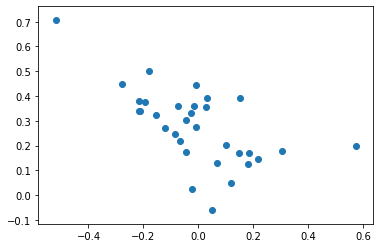




Epoch   1999.Loss 0.634  GEN Loss 0.763


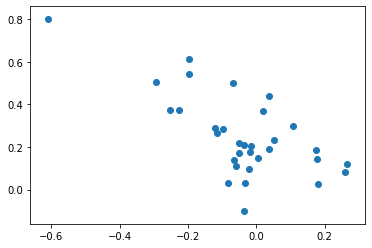




Epoch   2999.Loss 0.626  GEN Loss 0.751


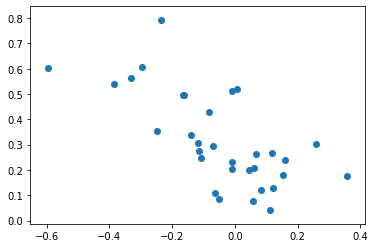




Epoch   3999.Loss 0.628  GEN Loss 0.762


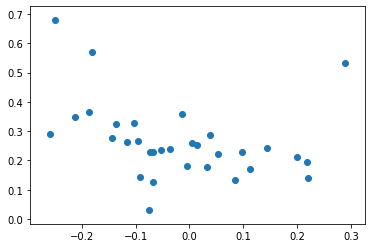




Epoch   4999.Loss 0.633  GEN Loss 0.762


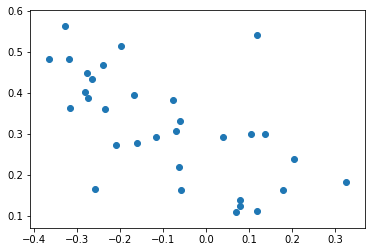




Epoch   5999.Loss 0.636  GEN Loss 0.759


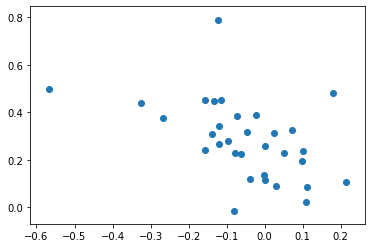




Epoch   6999.Loss 0.638  GEN Loss 0.762


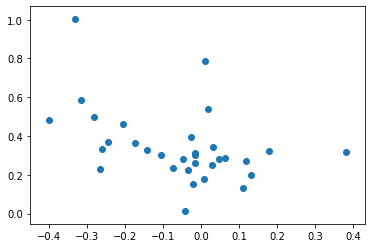




Epoch   7999.Loss 0.628  GEN Loss 0.758


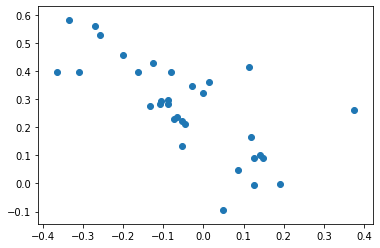




Epoch   8999.Loss 0.624  GEN Loss 0.759


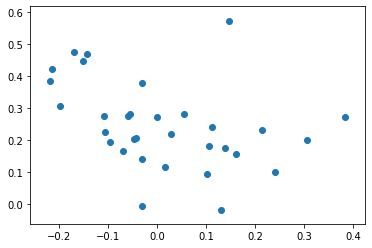




Epoch   9999.Loss 0.636  GEN Loss 0.759


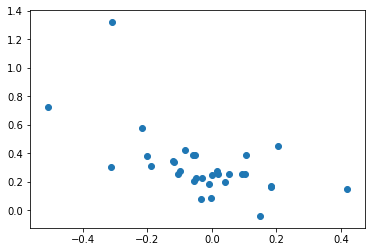

In [37]:
discriminator_model =  define_discriminator(2)
generator_model = define_generator(5)
trained_gen = train_GAN(discriminator=discriminator_model,generator=generator_model)

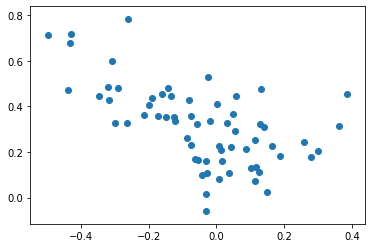

In [71]:
        X_fake = generate_latent_points(5, 64)

        X_fake = Variable(torch.from_numpy(X_fake)).float()
        fake_gen_output = generator_model(X_fake.float()).detach()
        plt.scatter(fake_gen_output[:,0],fake_gen_output[:,1])